# Face Recognition Using Siamese Network

We will understand the siamese network by building the face recognition model. The objective of our network is to understand whether two faces are similar or dissimilar. We use AT & T's the Database of Faces which can be downloaded from here (https://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html)

Once you have downloaded and extracted the archive, you can see the folders like s1, s2 up to s40 as shown here:

![title](Images/1.png)

Each of these folders has 10 different images of a single person taken from various angles. For an instance, let us open folder s1. As you can see, there are 10 different images of a single person:

각각의 폴더는 다양한 각도에서 찍은 한 사람의 10개의 다른 이미지를 가지고 있다. 예를 들어, s1 폴더를 열자. 보다시피 한 사람의 이미지는 다음과 같이 10가지다.

![title](Images/2.png)

We will open and check folder s13,

![title](Images/3.png)

As we know that siamese networks require inputs as a pair along with the label, we have to create our data in such a way. So we will take two images randomly from the same folder and mark it as a genuine pair and we will take a single image from two different folders and mark them as an imposite pair. A sample data is shown in the below figure, as you can notice a genuine pair has images of the same person and imposite pair has images of a different person. 

샴 네트워크는 라벨과 함께 쌍으로 입력을 필요로 한다는 것을 우리가 알고 있듯이, 우리는 그러한 방식으로 데이터를 생성해야 한다. 그래서 우리는 같은 폴더에서 무작위로 두 개의 이미지를 찍어서 genuine 쌍으로 표시하고, 다른 두 폴더에서 하나의 이미지를 찍어서 imposite 쌍으로 표시한다. 아래 그림에는 샘플 데이터가 나와 있는데, 실제 한 쌍은쌍은 다른 사람의 이미지를 가지고 있다는 것을 알 수 있다.

![title](Images/5.png)

Once we have our data as pairs along with their labels, we train our siamese network. From the image pair, we feed one image to the network A and another image to the network B. The role of these two networks is only to extract the feature vectors. So, we use two convolution layers with relu activations for extracting the features. Once we have learned the feature, we feed the resultant feature vector from both of the networks to the energy function which measures the similarity,  we use Euclidean distance as our energy function. So, we train our network by feeding the image pair to learn the semantic similarity between them.  Now, we will see this step by step. 


First, we will import the required libraries.

일단 우리가 그들의 라벨과 함께 우리의 데이터를 쌍으로 얻으면, 우리는 샴 네트워크를 훈련시킨다. 이미지 쌍에서 네트워크 A에 이미지 하나를, 네트워크 B에 이미지 하나를 공급한다. 이 두 네트워크의 역할은 오직 피처 벡터를 추출하는 것이다. 그래서 우리는 특징들을 추출하기 위해 두 개의 콘볼루션 레이어와 함께 relu 활성화 함수를 사용한다. 피처를 알게 되면, 우리는 두 네트워크로부터 유사성을 측정하는 에너지 함수에 결과적인 형상 벡터를 공급하고, 우리의 에너지 함수로 유클리드 거리를 사용한다. 그래서, 우리는 이미지 쌍을 공급하여 그들 사이의 의미적 유사성을 학습함으로써 우리의 네트워크를 훈련시킨다. 이제 우리는 이것을 차근차근 보게 될 것이다.

In [1]:
import re
import numpy as np
from PIL import Image

from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers import Activation
from keras.layers import Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.models import Sequential, Model
from keras.optimizers import RMSprop

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn



Now, we define a function for reading our input image. The function read_image takes input as an image and returns the numpy array.

read_image 함수는 이미지를 입력으로 하며 numpy 배열을 반환한다

In [2]:
def read_image(filename, byteorder='>'):
    
    #first we read the image, as a raw file to the buffer
    with open(filename, 'rb') as f:
        buffer = f.read()
    
    #using regex, we extract the header, width, height and maxval of the image
    header, width, height, maxval = re.search(
        b"(^P5\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    
    #then we convert the image to numpy array using np.frombuffer which interprets buffer as one dimensional array
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))



For an example, Let us open one image,

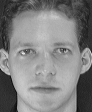

In [3]:
Image.open("data/orl_faces/s1/1.pgm")

When we feed this image to our read_image function, it will return as the numpy array,

위의 이미지를 read_image() 함수에 넣었을 때 numpy 배열을 반환한다

In [4]:
img = read_image('data/orl_faces/s1/1.pgm')
for x in range(img.shape[0]):
    for y in range(img.shape[1]):
        print(img[x,y], end=' ')
    print()

48 49 45 47 49 57 39 42 53 49 53 60 76 91 99 95 80 75 66 54 47 49 50 43 46 53 61 70 84 105 133 130 110 94 81 107 95 80 57 55 66 86 80 74 65 71 62 84 52 74 71 67 64 88 68 71 75 66 57 61 62 52 47 50 58 60 64 66 57 46 54 66 80 80 68 71 87 64 77 66 83 77 58 46 41 43 56 55 51 56 56 54 
45 52 39 46 56 45 39 47 48 40 39 50 44 69 70 67 72 59 51 52 51 48 52 53 64 75 81 85 98 110 107 130 127 109 101 80 93 94 76 58 81 78 83 78 72 77 60 74 61 75 79 74 64 93 67 69 70 53 51 50 59 55 51 47 47 47 61 61 62 47 44 64 75 78 58 66 82 81 86 73 70 68 57 47 38 39 39 51 53 52 50 51 
45 50 42 51 51 45 40 48 44 37 36 37 44 49 52 43 56 51 47 44 46 61 72 77 79 85 100 107 111 122 144 118 123 113 111 85 80 80 83 69 62 73 100 83 86 80 73 76 67 69 80 87 79 85 68 72 56 55 47 43 45 49 43 52 57 64 71 59 55 47 45 62 80 76 80 80 91 88 94 82 70 63 54 52 47 41 33 49 51 48 53 50 
49 46 47 47 50 47 42 45 40 44 61 61 49 65 62 61 54 67 77 61 53 55 57 64 68 62 71 97 112 89 113 133 113 103 81 94 74 73 75 75 64 75 95 96 93 91 80 79

69 47 38 37 45 42 66 76 88 107 110 127 139 156 164 165 167 168 167 170 166 170 171 170 173 169 171 171 172 173 172 175 177 177 177 180 184 189 197 198 193 188 194 192 192 193 188 187 187 180 175 174 169 176 173 175 174 172 177 172 177 177 175 179 177 175 175 175 173 172 167 164 159 155 156 132 125 95 94 85 77 59 49 39 42 39 42 35 54 50 48 46 
61 50 34 43 70 41 53 64 80 106 116 127 142 156 164 162 165 166 166 167 166 171 174 171 174 171 173 171 173 170 173 174 176 177 179 182 186 184 195 197 193 196 194 191 183 189 188 187 186 181 176 175 170 172 172 175 173 175 176 175 176 176 175 177 174 177 176 172 173 171 167 164 157 156 156 144 119 96 88 70 106 57 67 41 38 38 36 31 46 48 49 45 
57 63 23 62 82 37 50 70 88 107 116 140 155 160 163 158 165 164 163 164 166 169 171 170 173 173 176 176 175 171 174 172 176 176 181 182 182 187 195 192 194 197 190 195 191 191 188 185 184 177 175 176 170 168 168 175 170 170 175 174 175 176 177 178 175 174 175 178 172 173 166 166 157 156 151 148 127 101 81 82 

47 49 47 44 43 46 42 48 38 44 42 45 45 20 150 170 173 181 193 191 192 196 199 195 193 192 191 193 186 187 177 173 178 183 174 156 147 147 142 140 142 147 140 136 140 137 140 143 144 144 139 142 148 157 168 175 178 176 177 178 180 181 181 178 173 181 181 183 177 178 172 165 166 158 146 149 93 31 36 38 38 44 36 43 40 42 36 39 41 38 44 40 
49 50 48 46 47 44 44 43 40 45 45 43 45 31 97 168 172 184 188 193 194 197 197 197 195 192 195 191 180 173 157 139 141 145 135 123 121 115 107 95 98 113 112 111 110 117 126 119 120 114 114 115 113 119 125 144 155 157 155 163 171 181 180 181 177 181 180 182 178 172 171 162 163 160 139 141 88 32 40 37 42 36 45 37 37 44 36 39 38 39 44 42 
49 46 50 48 41 47 43 45 44 43 43 45 47 43 27 165 172 183 188 188 195 195 195 194 197 198 196 184 167 152 128 116 110 117 117 112 105 104 103 96 103 101 98 94 85 85 93 86 84 85 81 88 94 92 91 103 108 114 123 140 156 168 181 180 177 180 179 180 175 173 169 162 164 149 130 140 84 30 40 39 39 38 42 40 40 39 39 38 39 41 42 44 
4

In [5]:
img.shape

(112, 92)

Now, we define another function get_data for generating our data. As we know, for the Siamese network, data should be in the form of pairs (genuine and imposite) with a binary label.

First, we read the images (img1, img2) from the same directory and store them in the x_genuine_pair array and assign y_genuine to 1. Next, we read the images (img1, img2) from the different directory and store them in the x_imposite pair and assign y_imposite to 0.

Finally, we concatenate both x_genuine_pair, x_imposite to X and y_genuine, y_imposite to Y:

get_data 함수를 정의할 것이다. 샴 네트워크의 데이터는 이진 라벨의 형태여야 한다.

In [6]:
size = 2
total_sample_size = 10000


def get_data(size, total_sample_size):
    #read the image
    image = read_image('data/orl_faces/s' + str(1) + '/' + str(1) + '.pgm', 'rw+')
    #reduce the size
    print(image.shape)
    image = image[::size, ::size]
    print(image.shape)
    #get the new size
    dim1 = image.shape[0]
    dim2 = image.shape[1]

    count = 0
    
    #initialize the numpy array with the shape of [total_sample, no_of_pairs, dim1, dim2]
    x_geuine_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])  # 2 is for pairs
    y_genuine = np.zeros([total_sample_size, 1])
    
    for i in range(40):
        for j in range(int(total_sample_size/40)):
            ind1 = 0
            ind2 = 0
            
            #read images from same directory (genuine pair)
            while ind1 == ind2:
                ind1 = np.random.randint(10)
                ind2 = np.random.randint(10)
            
            # read the two images
            img1 = read_image('data/orl_faces/s' + str(i+1) + '/' + str(ind1 + 1) + '.pgm', 'rw+')
            img2 = read_image('data/orl_faces/s' + str(i+1) + '/' + str(ind2 + 1) + '.pgm', 'rw+')
            
            #reduce the size
            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]
            
            #store the images to the initialized numpy array
            x_geuine_pair[count, 0, 0, :, :] = img1
            x_geuine_pair[count, 1, 0, :, :] = img2
            
            #as we are drawing images from the same directory we assign label as 1. (genuine pair)
            y_genuine[count] = 1
            count += 1

    count = 0
    x_imposite_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])
    y_imposite = np.zeros([total_sample_size, 1])
    
    for i in range(int(total_sample_size/10)):
        for j in range(10):
            
            #read images from different directory (imposite pair)
            while True:
                ind1 = np.random.randint(40)
                ind2 = np.random.randint(40)
                if ind1 != ind2:
                    break
                    
            img1 = read_image('data/orl_faces/s' + str(ind1+1) + '/' + str(j + 1) + '.pgm', 'rw+')
            img2 = read_image('data/orl_faces/s' + str(ind2+1) + '/' + str(j + 1) + '.pgm', 'rw+')

            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]

            x_imposite_pair[count, 0, 0, :, :] = img1
            x_imposite_pair[count, 1, 0, :, :] = img2
            #as we are drawing images from the different directory we assign label as 0. (imposite pair)
            y_imposite[count] = 0
            count += 1
            
    #now, concatenate, genuine pairs and imposite pair to get the whole data
    X = np.concatenate([x_geuine_pair, x_imposite_pair], axis=0)/255
    Y = np.concatenate([y_genuine, y_imposite], axis=0)

    return X, Y

Now, we generate our data and check our data size. As you can see we have 20,000 data points, out of these 10,000 are genuine pairs and 10,000 are imposite pairs. 

이제 데이터를 생성하고 데이터 크기를 확인한다. 보시다시피 20000 데이터 중 10000개는 genuine 이고, 10000개는 imposite 이다.

In [7]:
X, Y = get_data(size, total_sample_size)

(112, 92)
(56, 46)


In [8]:
X.shape

(20000, 2, 1, 56, 46)

In [9]:
Y.shape

(20000, 1)

Next, we split our data for training and testing with 75% training and 25% testing proportions:

데이터를 훈련용 테스트용으로 나누기 위해 75 / 25 비율로 나눈다

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.25)

Now that, we have successfully generated our data, we build our siamese network. First, we define the base network which is basically a convolutional network used for feature extraction. We build two convolutional layers with rectified linear unit (ReLU) activations and max pooling followed by flat layer.

우리는 성공적으로 데이터를 생성했고 샴 네트워크를 구축했다. 첫째, 기본적으로는 피처 추출에 사용되는 콘볼루션 네트워크인 베이스 네트워크를 정의한다. 우리는 ReLU 활성함수와 Max 풀링에 이어 플랫 레이어를 가진 두 개의 콘볼루션 레이어를 구축한다

In [11]:
def build_base_network(input_shape):
    
    seq = Sequential()
    
    nb_filter = [6, 12]
    kernel_size = 3
    
    
    #convolutional layer 1
    seq.add(Convolution2D(nb_filter[0], kernel_size, kernel_size, input_shape=input_shape,
                          border_mode='valid', dim_ordering='th'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2)))  
    seq.add(Dropout(.25))
    
    #convolutional layer 2
    seq.add(Convolution2D(nb_filter[1], kernel_size, kernel_size, border_mode='valid', dim_ordering='th'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='th')) 
    seq.add(Dropout(.25))

    #flatten 
    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(50, activation='relu'))
    return seq


In [12]:
input_dim = x_train.shape[2:]
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)

In [13]:
base_network = build_base_network(input_dim)
feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(6, (3, 3), input_shape=(1, 56, 46..., padding="valid", data_format="channels_first")`
  # This is added back by InteractiveShellApp.init_path()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(12, (3, 3), padding="valid", data_format="channels_first")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_first")`


These feat_vecs_a and feat_vecs_b are the feature vectors of our image pair. Next, we feed this feature vectors to the energy function to compute the distance between them, we use Euclidean distance as our energy function.

이러한 feat_vcs_a와 feat_vcs_b는 우리 이미지 쌍의 피처 벡터들이다. 다음으로, 우리는 이 피처 벡터를 에너지 함수에 넣어 그들 사이의 거리를 계산하고, 우리는 우리의 에너지 함수로 유클리드 거리를 사용한다.

In [14]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [15]:
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])

 Now, we set the epoch length to 13 and we use RMS prop for optimization and define our model.

In [16]:
epochs = 13
rms = RMSprop()

In [17]:
model = Model(input=[img_a, img_b], output=distance)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("la...)`
  """Entry point for launching an IPython kernel.


Next, we define our loss function as contrastive_loss function and compile the model. 

In [18]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [19]:
model.compile(loss=contrastive_loss, optimizer=rms)

In [20]:
img_1 = x_train[:, 0]
img2 = x_train[:, 1]

In [21]:
model.fit([img_1, img2], y_train, validation_split=.25,
          batch_size=128, verbose=2, nb_epoch=epochs)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  



Train on 11250 samples, validate on 3750 samples
Epoch 1/13
 - 40s - loss: 0.1426 - val_loss: 0.0627
Epoch 2/13
 - 35s - loss: 0.0737 - val_loss: 0.0380
Epoch 3/13
 - 35s - loss: 0.0531 - val_loss: 0.0290
Epoch 4/13
 - 35s - loss: 0.0414 - val_loss: 0.0224
Epoch 5/13
 - 34s - loss: 0.0353 - val_loss: 0.0173
Epoch 6/13
 - 34s - loss: 0.0304 - val_loss: 0.0167
Epoch 7/13
 - 34s - loss: 0.0270 - val_loss: 0.0182
Epoch 8/13
 - 35s - loss: 0.0246 - val_loss: 0.0169
Epoch 9/13
 - 34s - loss: 0.0225 - val_loss: 0.0127
Epoch 10/13
 - 34s - loss: 0.0207 - val_loss: 0.0122
Epoch 11/13
 - 34s - loss: 0.0186 - val_loss: 0.0104
Epoch 12/13
 - 40s - loss: 0.0168 - val_loss: 0.0081
Epoch 13/13
 - 38s - loss: 0.0158 - val_loss: 0.0073


Now, we make predictions with test data

테스트 데이터를 통해 예측을 수행한다.

In [22]:
pred = model.predict([x_test[:, 0], x_test[:, 1]])

In [23]:
def compute_accuracy(predictions, labels):
    return labels[predictions.ravel() < 0.5].mean()

Finally, we check our model accuracy. 

모델의 정확성을 체크한다.

In [24]:
compute_accuracy(pred, y_test)

0.9889807162534435